In [1]:
# import ncnn
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
import torch.onnx
import torchvision
import os
from torch.utils.data import Dataset
from torchvision.transforms import v2 as T
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#Global vars
batch_size = 128
num_classes = 26
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dir = "../ncnn_out"
if not os.path.exists(dir):
        os.makedirs(dir)

In [17]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_features=num_classes):
        super(CNN, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, out_features)
        )

    def forward(self, img):
        img = self.conv1(img)
        img = self.conv2(img)
        img = self.conv3(img)
        img = self.fc(img)
        return img

    def loss(self, x, label):
        loss = self.criterion(x, label)
        return loss
    

class GestureDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.classes = self.data['label']

        self.img = self.data.drop('label', axis=1)
        self.img = self.img / 255.0
        self.img = self.img.values.reshape(-1, 28, 28, 1)

        self.transform = T.Compose([T.ToPILImage(), T.RandomRotation(10),
                                    T.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5)),
                                    T.RandomResizedCrop(28, scale=(1.0, 2)), T.ToImage(),
                                    T.ToDtype(torch.float32, scale=True)])

    def __len__(self):
        return len(self.img)

    def __getitem__(self, index):
        label = self.classes[index]
        img = self.img[index]
        img = self.transform(img)

        label = torch.LongTensor([label])
        img = img.float()

        return img, label

def dataset(train_path, test_path, batch_size=128):
    train_dataset = GestureDataset(train_path)
    test_dataset = GestureDataset(test_path)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

train_loader, test_loader = dataset('../mnist-sign-language/mnist_sign_language_train.csv', 
                                                     '../mnist-sign-language/mnist_sign_language_test.csv', 
                                                    128)

tensor([[149, 149, 150, 150, 150, 151, 151, 150, 151, 152, 152, 152, 152, 152,
         153, 153, 151, 152, 152, 153, 152, 152, 151, 151, 150, 150, 150, 149],
        [150, 150, 150, 152, 152, 151, 152, 152, 152, 152, 152, 153, 154, 153,
         154, 154, 153, 154, 153, 154, 153, 153, 152, 152, 152, 151, 150, 151],
        [150, 151, 151, 152, 152, 152, 153, 153, 152, 152, 152, 153, 154, 154,
         155, 155, 154, 154, 155, 155, 155, 155, 154, 153, 153, 151, 151, 152],
        [150, 151, 151, 152, 152, 152, 154, 154, 154, 154, 154, 153, 154, 155,
         156, 157, 157, 156, 155, 156, 155, 154, 154, 155, 152, 154, 153, 153],
        [151, 152, 152, 152, 154, 154, 154, 154, 154, 155, 157, 156, 156, 156,
         154, 150, 146, 147, 146, 147, 143, 137, 126, 126, 142, 139, 152, 154],
        [152, 153, 153, 154, 154, 155, 154, 155, 155, 154, 153, 150, 144, 143,
         145, 139, 142, 144, 157, 157, 147, 139, 128, 119, 130, 113, 147, 156],
        [151, 153, 153, 155, 155, 156, 155, 15

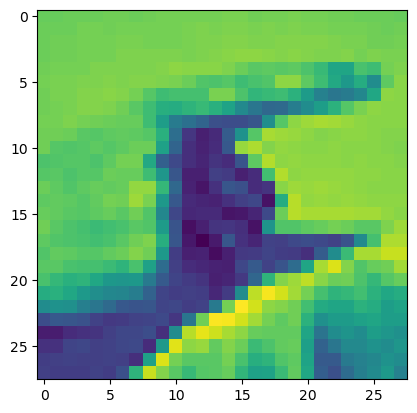

In [58]:
# img, label = next(iter(test_loader))
# img = torch.reshape(img[0],(28,28))
image = pd.read_csv("../mnist-sign-language/mnist_sign_language_test.csv")
img = torch.reshape(torch.from_numpy(image.head(1).values[0][1:]),(28,28))

plt.imshow(img)
print(img)

In [9]:
#Converting to NCNN type
#Source: https://github.com/Tencent/ncnn/wiki/use-ncnn-with-pytorch-or-onnx
weights = torch.load("../weights/mnist-sign-language/model.pth")
model = CNN()
model.load_state_dict(weights)
model.eval()

torch_out = torch.onnx._export(model, torch.rand(128, 1, 28, 28), dir+"/resnet18.onnx", export_params=True) # Export the model
!python3 -m onnxsim {dir+"/resnet18.onnx"} {dir+"/resnet18-sim.onnx"}
!onnx2ncnn {dir+"/resnet18-sim.onnx"} {dir+"/resnet18.param"} {dir+"/resnet18.bin"}

/var/folders/n1/xzlv_l050l51pv993nmt4rpm0000gn/T/ipykernel_28543/2017182477.py:8: FutureWarning: 'torch.onnx._export' is deprecated in version 1.12.0 and will be removed in 2.0. Please use `torch.onnx.export` instead.
  torch_out = torch.onnx._export(model, torch.rand(128, 1, 28, 28), dir+"/resnet18.onnx", export_params=True) # Export the model


Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃            ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Constant   │ 8              │ 8                │
│ Conv       │ 3              │ 3                │
│ Flatten    │ 1              │ 1                │
│ Gemm       │ 1              │ 1                │
│ LeakyRelu  │ 3              │ 3                │
│ MaxPool    │ 2              │ 2                │
│ Model Size │ 411.5KiB       │ 412.0KiB         │
└────────────┴────────────────┴──────────────────┘


In [10]:
ncnn_model = ncnn.Net()
ncnn_model.load_param(dir+"/resnet18.param")
ncnn_model.load_model(dir+"/resnet18.bin")

imgs, vals = next(iter(test_loader))
img = imgs[0]

ncnn.Mat.from_pixels(img, 1,28,28)


TypeError: from_pixels(): incompatible function arguments. The following argument types are supported:
    1. (array: buffer, type: int, w: int, h: int, allocator: ncnn.ncnn.Allocator = None) -> ncnn.ncnn.Mat
    2. (array: buffer, type: int, w: int, h: int, stride: int, allocator: ncnn.ncnn.Allocator = None) -> ncnn.ncnn.Mat

Invoked with: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.9569, 0.9647, 0.9843, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.0000, 0.0000],
         [0.8196, 0.8667, 0.9098, 0.9333, 0.9608, 0.9725, 0.9882, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.0000, 0.0000],
         [0.8392, 0.8784, 0.9137, 0.9451, 0.9725, 0.9843, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.7843, 0.9725, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.0000, 0.0000],
         [0.8510, 0.8902, 0.9333, 0.9569, 0.9882, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.6706, 0.5059, 0.5059, 0.7569, 0.7843, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.0000],
         [0.8667, 0.9020, 0.9490, 0.9647, 0.9961, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 0.6745, 0.4706, 0.7961, 0.7098, 0.5882, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.0000],
         [0.8431, 0.8745, 0.9137, 0.9490, 0.9882, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 0.9451, 0.8314, 0.9020, 1.0000,
          1.0000, 0.8392, 0.4980, 0.8431, 0.6706, 0.5529, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.0000],
         [0.8549, 0.8902, 0.9255, 0.9647, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8902, 0.6471, 0.9608,
          1.0000, 0.8510, 0.5098, 0.8902, 0.7490, 0.6392, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.0000],
         [0.8667, 0.9020, 0.9333, 0.9725, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.8196, 1.0000, 1.0000, 1.0000, 0.6745, 0.5451,
          1.0000, 0.7216, 0.4588, 1.0000, 0.7843, 0.8314, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.0000],
         [0.8667, 0.9098, 0.9451, 0.9843, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 0.8902, 0.8196, 0.7843, 1.0000, 1.0000, 0.7569, 0.3647,
          0.6235, 0.3961, 0.4353, 0.8745, 0.6745, 0.9608, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.0000],
         [0.8745, 0.9216, 0.9569, 0.9882, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 0.9765, 0.7176, 0.4588, 1.0000, 1.0000, 0.7216, 0.3608,
          0.2549, 0.4706, 0.6980, 0.6980, 0.7961, 0.6706, 0.6706, 0.9765,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.8863, 0.9216, 0.9608, 0.9961, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.8627, 0.4353, 0.8902, 0.9961, 0.6706,
          0.3490, 0.4588, 0.8431, 0.9020, 0.7608, 0.6157, 0.6000, 0.6745,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.8745, 0.8980, 0.9333, 0.9765, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.7451, 0.4431, 0.6980, 0.9647, 0.7804,
          0.3529, 0.8863, 1.0000, 0.9569, 0.7333, 0.5529, 0.6118, 0.6471,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.8784, 0.9020, 0.9569, 0.9882, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.6353, 0.3608, 0.5059, 1.0000, 0.8510,
          0.4235, 1.0000, 1.0000, 0.9216, 0.7176, 0.5647, 0.5333, 0.9255,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.8902, 0.9137, 0.9725, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.8902, 0.8510, 0.9451, 0.6235, 0.2902, 0.3059, 0.9882, 0.8196,
          0.7216, 1.0000, 1.0000, 0.8078, 0.6824, 0.5294, 0.4431, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.9137, 0.9451, 0.9843, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.9451, 0.7333, 0.8196, 0.6000, 0.3176, 0.5529, 1.0000, 1.0000,
          1.0000, 1.0000, 0.9216, 0.7490, 0.6235, 0.4863, 0.4980, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.9216, 0.9569, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.9882, 0.6980, 0.6706, 0.6471, 0.8314, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.8510, 0.7216, 0.5569, 0.5569, 0.4235, 0.9882,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.9255, 0.9725, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.7843, 0.9137, 0.8980, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.9451, 0.7922, 0.6588, 0.5059, 0.3843, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.0000, 0.9333, 0.9843, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.9098, 1.0000, 0.8980, 1.0000, 1.0000, 1.0000,
          1.0000, 0.9882, 0.8431, 0.7176, 0.5922, 0.4549, 0.5529, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.0000, 0.9490, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 0.9490, 1.0000, 1.0000, 1.0000,
          1.0000, 0.9882, 0.7608, 0.6706, 0.5451, 0.4980, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.0000, 0.9725, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 0.9765, 1.0000, 1.0000, 1.0000,
          1.0000, 0.8902, 0.6863, 0.6235, 0.4941, 0.9882, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.0000, 0.9961, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.9569, 0.8039, 0.6392, 0.5333, 0.7843, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.8784, 0.6980, 0.5922, 0.5765, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 0.8980],
         [0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9725, 1.0000,
          0.9490, 0.8078, 0.6235, 0.5176, 0.9216, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.8510, 0.3725],
         [0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9765, 0.9725,
          0.8863, 0.7804, 0.6353, 0.4784, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 0.6275, 0.3294, 0.2902],
         [0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9961, 0.9098,
          0.8510, 0.7725, 0.6353, 0.4863, 1.0000, 1.0000, 1.0000, 1.0000,
          0.4824, 0.2902, 0.1725, 0.2431],
         [0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8863,
          0.8510, 0.7608, 0.6118, 0.4941, 1.0000, 1.0000, 1.0000, 1.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8902,
          0.8392, 0.7608, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000]]]), 1, 28, 28

ncnn.ncnn.Mat